## Fitting BehaveNet to an example dataset

This series of notebooks will walk you through how to download an example dataset and fit the various models in the BehaveNet toolbox.

Before beginning, first make sure that you have properly installed the BehaveNet package and environment by following the instructions [here](https://behavenet.readthedocs.io/en/latest/source/installation.html). Specifically, (1) set up the Anaconda virtual environment; and (2) install the `BehaveNet` and `ssm` packages. You do not need to set user paths at this time (this will be covered below).

To illustrate the use of BehaveNet we will use an example dataset from [Musall et al 2019](https://www.nature.com/articles/s41593-019-0502-4), which is also one of the datasets used in the original [BehaveNet paper](https://papers.nips.cc/paper/9701-behavenet-nonlinear-embedding-and-bayesian-neural-decoding-of-behavioral-videos).

Briefly, a head-fixed mouse performed a visual decision-making task while neural activity across dorsal cortex was optically recorded using widefield calcium imaging. We used the [LocaNMF](https://www.biorxiv.org/content/10.1101/650093v2) decomposition approach to extract signals from the calcium imaging video. Behavioral data was recorded using two cameras: one side view and one bottom view. Grayscale video frames were downsampled to 128x128 pixels. Data consists of 1126 trials across two sessions in the same mouse, with 189 frames per trial (30 Hz framerate). Neural activity was acquired at the same frame rate.

The data are stored on the Cold Spring Harbor data repository; you will download this data after setting some user paths.

**Note**: make sure that you are running the `behavenet` ipython kernel - you should see the current ipython kernel name in the upper right hand corner of this notebook. If it is not `behavenet` (for example it might be `Python 3`) then change it using the dropdown menus above: `Kernel > Change kernel > behavenet`. If you do not see `behavenet` as an option see [here](https://behavenet.readthedocs.io/en/latest/source/installation.html#environment-setup).

<br>

### Contents
* [Set user paths](#0.-Set-user-paths)
* [Download the data](#1.-Download-the-data)
* [Add dataset hyperparameters](#2.-Add-dataset-hyperparameters)

### 0. Set user paths
First set the paths to the directories where data, results, and figures will be stored on your local machine. Note that the data is ~7.5GB, so make sure that your data directory has enough space.

A note about the BehaveNet path structure: every dataset is uniquely identified by a lab id, experiment id, animal id, and session id. Paths to data and results contain directories for each of these id types. For example, a sample data path will look like `/home/user/data/lab_id/expt_id/animal_id/session_id/data.hdf5`. In this case the base data directory is `/home/user/data/`.

The downloaded zip file contains two datasets, which will automatically be saved as:
* `data_dir/musall/vistrained/mSM36/05-Dec-2017/data.hdf5`
* `data_dir/musall/vistrained/mSM36/07-Dec-2017/data.hdf5`

Additionally, the zip file contains already trained convolutional neural networks (the most time consuming step of the pipeline), which will automatically be saved in the directories:
* `results_dir/musall/vistrained/mSM36/05-Dec-2017/ae/conv/09_latents/ae-example/`
* `results_dir/musall/vistrained/mSM36/07-Dec-2017/ae/conv/09_latents/ae-example/`
* `results_dir/musall/vistrained/mSM36/multisession-00/ae/conv/09_latents/ae-example/`

The first two directories contain AEs trained on the individual sessions; the third directory contains an AE trained on both sessions simultaneously.

To set the user paths, run the cell below.

[Back to contents](#Contents)

In [11]:
from behavenet import setup
setup()

Directories are now stored in /n/home13/jbw25/.behavenet/directories.json


The directory file is stored in your user home directory; this is a json file that can be updated in a text editor at any time.

### 1. Download the data
Run the cell below; data and results will be stored in the directories provided in the previous step.

[Back to contents](#Contents)

In [ ]:
import os
import io
import shutil
import requests
import zipfile as zf
from behavenet import get_user_dir

url = 'http://labshare.cshl.edu/shares/library/repository/38599/behavenet_example_data.zip'

print('Downloading data - this may take several minutes')

# fetch data from CSHL data repository
print('fetching data from url...', end='')
r = requests.get(url, stream=True)
z = zf.ZipFile(io.BytesIO(r.content))
print('done')

# extract data
data_dir = get_user_dir('data')
print('extracting data to %s...' % data_dir, end='')
for file in z.namelist():
    if file.startswith('behavenet_ex/data/'):
        z.extract(file, data_dir)
# clean up paths
shutil.move(os.path.join(data_dir, 'behavenet_ex', 'data', 'musall'), data_dir)
shutil.rmtree(os.path.join(data_dir, 'behavenet_ex'))
print('done')

# extract results
results_dir = get_user_dir('save')
print('extracting results to %s...' % results_dir, end='')
for file in z.namelist():
    if file.startswith('behavenet_ex/results/'):
        z.extract(file, results_dir)
# clean up paths
shutil.move(os.path.join(results_dir, 'behavenet_ex', 'results', 'musall'), results_dir)
shutil.rmtree(os.path.join(results_dir, 'behavenet_ex'))
print('done')

### 2. Add dataset hyperparameters
The last step is to save some of the dataset hyperparameters in their own json file. This is used to simplify command line arguments to model fitting functions. Run the cell below and input the following information when prompted:

* name of experimenter/lab: `musall` (note: quotes are not needed around strings)
* name of experiment: `vistrained`
* example animal name: `mSM36`
* example session name: `05-Dec-2017`
* number of camera views: `2` - this can refer to color channels (for RGB data) and/or multiple camera views, which should be concatenated along the color channel dimension. In the Musall dataset we use grayscale images from two camera views, so a trial with 189 frames will have a block of video data of shape (189, 2, 128, 128)
* number of y pixels: `128`
* number of x pixels: `128`
* are you applying any masks to the video?: `False` - an optional output mask can be applied to each video frame if desired; these output masks must also be stored in the data.hdf5 files under the key "masks".
* frame rate of video: `30` - behavenet assumes that the video data and neural data are binned at the same temporal resolution
* neural data type: `ca` - either ca for 2-photon/widefield data, or spikes for ephys data. This parameter controls the noise distribution for encoding models, as well as several other model hyperparameters.

To save these, run the cell below and enter them one at a time.

[Back to contents](#Contents)

In [9]:
from behavenet import add_dataset
add_dataset()

Please enter the following information about the dataset:


Please enter the following information about the behavioral video:
Please enter the following information about the neural data:
Dataset params are now stored in /n/home13/jbw25/.behavenet/Tom_testing_params.json


## Decoding the type of data stored in the parquet file to confirm params file: 

In [10]:
import json

#open dataset params
dataset_param = '/n/home13/jbw25/.behavenet/Tom_testing_params.json'
with open(dataset_param, 'r') as f:
    dataset_params = json.load(f)

print(dataset_params)

{'lab': 'Tom', 'expt': 'testing', 'animal': '1', 'session': '1', 'n_input_channels': 1, 'y_pixels': 140, 'x_pixels': 170, 'use_output_mask': False, 'frame_rate': 150.0, 'neural_type': 'spikes', 'neural_bin_size': 0.006666666666666667, 'approx_batch_size': 200}


In [ ]:
import os
import pandas as pd
data_dir = '/n/holylabs/LABS/bsabatini_lab/Users/jbw25/Tom_behavenet/behaveNet_data.parquet'

df = pd.read_parquet(data_dir)
print(df.head())
print(df.columns)

   trial  frame_index                                        neural_data  \
0      0            0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      0            1  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
2      0            2  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
3      0            3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      0            4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                          frame_data  
0  b'\xd2\xdf\xf3\xfc\xf8\xfc\xfd\xfd\xfd\xfd\xfd...  
1  b'\xd2\xde\xf4\xfb\xfa\xfc\xfd\xfd\xfd\xfd\xfd...  
2  b'\xd2\xde\xf4\xfb\xfa\xfc\xfd\xfd\xfd\xfd\xfd...  
3  b'\xd2\xde\xf4\xfb\xfa\xfc\xfd\xfd\xfd\xfd\xfd...  
4  b'\xd3\xde\xf4\xfb\xfa\xfc\xfd\xfd\xfd\xfd\xfd...  
(478629, 4)
Index(['trial', 'frame_index', 'neural_data', 'frame_data'], dtype='object')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

array = np.frombuffer(df['frame_data'][0], dtype=np.uint8)
num_pixels = len(np.frombuffer(df['frame_data'][0], dtype=np.uint8))
print("Total pixels:", num_pixels)

possible_shapes = [(s, num_pixels // s) for s in range(10, 1000) if num_pixels % s == 0]
print("Possible shapes:", possible_shapes)

Total pixels: 23800


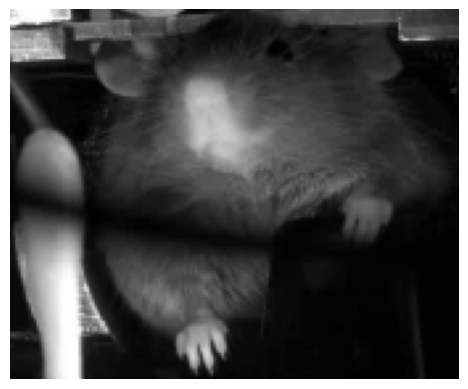

In [ ]:
height, width = 140, 170  
image = array.reshape((height, width))

# Display the image
plt.imshow(image, cmap="gray")
plt.axis("off")  
plt.show()

If the dataset parameters are successfully stored you will see the message "Dataset params are now stored in [some directory]" as the last output line in the above cell.

You are now ready to start fitting and analyzing models; before doing so, however, it might be useful to read more about the basics of the BehaveNet package [here](https://behavenet.readthedocs.io/en/latest/source/user_guide.intro.html).